In [1]:
# Repeating the MNIST experiment
""" An attempt to obtain impressive results on MNIST.
    Code extracted from: https://github.com/shahariarrabby/Mnist_cnn_Swish
    Expected results > 99.5%
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import RMSprop, adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# For adding new activation function
from keras import backend as K
from keras.datasets import mnist
from keras.utils.generic_utils import get_custom_objects
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", Y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


In [4]:
# Normalization
nb_classes = 10
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

In [6]:
# Set the random seed
random_seed = 2

In [7]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

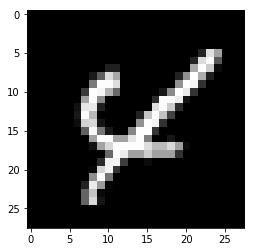

In [8]:
# Some examples
g = plt.imshow(X_train[0], cmap='binary_r')

In [9]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.reshape(-1,28,28,1)
X_val = X_val.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
# test = test.values.reshape(-1,28,28,1)
print(X_train.shape, X_val.shape, X_test.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (10000, 28, 28, 1)


In [10]:
def swish(x):
    return (K.sigmoid(x) * x)

def e_swish_2(x):
    sigmoid = K.sigmoid(x)
    return K.maximum(x*sigmoid, x*(2-sigmoid))

In [11]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
def create(act):
    model = Sequential()
    # First conv block
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', input_shape = (28,28,1)))
    model.add(Activation(act))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="Sme", input_dim=X_train.shape[1:]))
    model.add(Activation(act))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    # Second conv block
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same'))
    model.add(Activation(act))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same'))
    model.add(Activation(act))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    # Classification
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation(act))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation(sigmoid))
    
    return model

In [13]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.125, # Randomly zoom image 
        width_shift_range=0.125,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.125,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
# RELU
partial = []
for i in range(3):
    # Define the optimizer - Common to all models
    opt = adam(lr=0.001, epsilon=1e-08, decay=0.0)
    # Set a learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001) 
    # Common params 
    epochs = 35
    batch_size = 86
    # Create and compile the model
    model = create("relu")
    # Compile the model
    model.compile(optimizer = opt , loss = "categorical_crossentropy", metrics=["accuracy"])
    # Train the model
    history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_val,Y_val),
                                  verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                                  , callbacks=[learning_rate_reduction])
    scores = model.evaluate(X_test, Y_test)
    ind = [history.history, scores]
    print(ind)
    partial.append(ind)

print(partial)

Epoch 1/30


In [ ]:
# ESWISH2
partial = []
for i in range(3):
    # Define the optimizer - Common to all models
    opt = adam(lr=0.001, epsilon=1e-08, decay=0.0)
    # Set a learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001) 
    # Common params 
    epochs = 35    # Turn epochs to 30 to get 0.9967 accuracy
    batch_size = 86
    # Create and compile the model
    model = create(e_swish_2)
    # Compile the model
    model.compile(optimizer = opt , loss = "categorical_crossentropy", metrics=["accuracy"])
    # Train the model
    history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_val,Y_val),
                                  verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                                  , callbacks=[learning_rate_reduction])
    scores = model.evaluate(X_test, Y_test)
    ind = [history.history, scores]
    print(ind)
    partial.append(ind)

print(partial)

Epoch 1/30


In [ ]:
# SWISH
partial = []
for i in range(3):
    # Define the optimizer - Common to all models
    opt = adam(lr=0.001, epsilon=1e-08, decay=0.0)
    # Set a learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001) 
    # Common params 
    epochs = 35    # Turn epochs to 30 to get 0.9967 accuracy
    batch_size = 86
    # Create and compile the model
    model = create(swish)
    # Compile the model
    model.compile(optimizer = opt , loss = "categorical_crossentropy", metrics=["accuracy"])
    # Train the model
    history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_val,Y_val),
                                  verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                                  , callbacks=[learning_rate_reduction])
    scores = model.evaluate(X_test, Y_test)
    ind = [history.history, scores]
    print(ind)
    partial.append(ind)

print(partial)

In [16]:
# RELU
partial = []
for i in range(2):
    # Define the optimizer - Common to all models
    opt = adam(lr=0.001, epsilon=1e-08, decay=0.0)
    # Set a learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001) 
    # Common params 
    epochs = 35    # Turn epochs to 30 to get 0.9967 accuracy
    batch_size = 86
    # Create and compile the model
    model = create("relu")
    # Compile the model
    model.compile(optimizer = opt , loss = "categorical_crossentropy", metrics=["accuracy"])
    # Train the model
    history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_val,Y_val),
                                  verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                                  , callbacks=[learning_rate_reduction])
    scores = model.evaluate(X_test, Y_test)
    ind = [history.history, scores]
    print(ind)
    partial.append(ind)

print(partial)

Epoch 1/35
627/627 [==============================] - 59s 95ms/step - loss: 0.4632 - acc: 0.8544 - val_loss: 0.0625 - val_acc: 0.9807
Epoch 2/35
627/627 [==============================] - 58s 93ms/step - loss: 0.1430 - acc: 0.9578 - val_loss: 0.0432 - val_acc: 0.9870
Epoch 3/35
627/627 [==============================] - 58s 93ms/step - loss: 0.1121 - acc: 0.9678 - val_loss: 0.0356 - val_acc: 0.9887
Epoch 4/35
627/627 [==============================] - 58s 93ms/step - loss: 0.0918 - acc: 0.9726 - val_loss: 0.0291 - val_acc: 0.9908
Epoch 5/35
627/627 [==============================] - 58s 93ms/step - loss: 0.0847 - acc: 0.9752 - val_loss: 0.0277 - val_acc: 0.9917
Epoch 6/35
627/627 [==============================] - 58s 93ms/step - loss: 0.0770 - acc: 0.9782 - val_loss: 0.0309 - val_acc: 0.9908
Epoch 7/35
627/627 [==============================] - 58s 93ms/step - loss: 0.0674 - acc: 0.9798 - val_loss: 0.0300 - val_acc: 0.9920
Epoch 8/35
627/627 [==============================] - 58s 93ms

Epoch 1/35
627/627 [==============================] - 59s 93ms/step - loss: 0.4752 - acc: 0.8509 - val_loss: 0.0612 - val_acc: 0.9813
Epoch 2/35
627/627 [==============================] - 58s 92ms/step - loss: 0.1509 - acc: 0.9550 - val_loss: 0.0393 - val_acc: 0.9887
Epoch 3/35
627/627 [==============================] - 58s 92ms/step - loss: 0.1105 - acc: 0.9679 - val_loss: 0.0396 - val_acc: 0.9888
Epoch 4/35
627/627 [==============================] - 58s 92ms/step - loss: 0.0918 - acc: 0.9720 - val_loss: 0.0387 - val_acc: 0.9898
Epoch 5/35
627/627 [==============================] - 58s 92ms/step - loss: 0.0855 - acc: 0.9749 - val_loss: 0.0320 - val_acc: 0.9903
Epoch 6/35
627/627 [==============================] - 58s 92ms/step - loss: 0.0763 - acc: 0.9773 - val_loss: 0.0243 - val_acc: 0.9920
Epoch 7/35
627/627 [==============================] - 58s 92ms/step - loss: 0.0688 - acc: 0.9799 - val_loss: 0.0258 - val_acc: 0.9920
Epoch 8/35
627/627 [==============================] - 58s 92ms

In [14]:
# E-SWISH-2
partial = []
for i in range(2):
    # Define the optimizer - Common to all models
    opt = adam(lr=0.001, epsilon=1e-08, decay=0.0)
    # Set a learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001) 
    # Common params 
    epochs = 35    # Turn epochs to 30 to get 0.9967 accuracy
    batch_size = 86
    # Create and compile the model
    model = create(e_swish_2)
    # Compile the model
    model.compile(optimizer = opt , loss = "categorical_crossentropy", metrics=["accuracy"])
    # Train the model
    history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_val,Y_val),
                                  verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                                  , callbacks=[learning_rate_reduction])
    scores = model.evaluate(X_test, Y_test)
    ind = [history.history, scores]
    print(ind)
    partial.append(ind)

print(partial)

Epoch 1/35
627/627 [==============================] - 84s 134ms/step - loss: 0.3896 - acc: 0.8804 - val_loss: 0.0557 - val_acc: 0.9820
Epoch 2/35
627/627 [==============================] - 81s 130ms/step - loss: 0.1404 - acc: 0.9590 - val_loss: 0.0463 - val_acc: 0.9850
Epoch 3/35
627/627 [==============================] - 81s 130ms/step - loss: 0.1127 - acc: 0.9669 - val_loss: 0.0420 - val_acc: 0.9853
Epoch 4/35
627/627 [==============================] - 81s 130ms/step - loss: 0.0968 - acc: 0.9712 - val_loss: 0.0398 - val_acc: 0.9880
Epoch 5/35
627/627 [==============================] - 81s 130ms/step - loss: 0.0925 - acc: 0.9723 - val_loss: 0.0313 - val_acc: 0.9913
Epoch 6/35
627/627 [==============================] - 81s 130ms/step - loss: 0.0871 - acc: 0.9751 - val_loss: 0.0334 - val_acc: 0.9915
Epoch 7/35
627/627 [==============================] - 82s 130ms/step - loss: 0.0810 - acc: 0.9762 - val_loss: 0.0384 - val_acc: 0.9905
Epoch 8/35
627/627 [==============================] - 8

Epoch 1/35
627/627 [==============================] - 81s 129ms/step - loss: 0.3970 - acc: 0.8767 - val_loss: 0.0502 - val_acc: 0.9842
Epoch 2/35
627/627 [==============================] - 81s 129ms/step - loss: 0.1424 - acc: 0.9584 - val_loss: 0.0366 - val_acc: 0.9885
Epoch 3/35
627/627 [==============================] - 81s 129ms/step - loss: 0.1085 - acc: 0.9687 - val_loss: 0.0388 - val_acc: 0.9860
Epoch 4/35
627/627 [==============================] - 81s 129ms/step - loss: 0.0987 - acc: 0.9711 - val_loss: 0.0319 - val_acc: 0.9905
Epoch 5/35
627/627 [==============================] - 81s 129ms/step - loss: 0.0899 - acc: 0.9745 - val_loss: 0.0372 - val_acc: 0.9892
Epoch 6/35
627/627 [==============================] - 81s 130ms/step - loss: 0.0825 - acc: 0.9763 - val_loss: 0.0264 - val_acc: 0.9918
Epoch 7/35
627/627 [==============================] - 81s 130ms/step - loss: 0.0828 - acc: 0.9761 - val_loss: 0.0247 - val_acc: 0.9928
Epoch 8/35
627/627 [==============================] - 8

In [ ]:
def e_swish_5(x):
    return K.maximum(-x*K.sigmoid(-x), x*K.sigmoid(x))

# SWISH
partial = []
for i in range(1):
    # Define the optimizer - Common to all models
    opt = adam(lr=0.001, epsilon=1e-08, decay=0.0)
    # Set a learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001) 
    # Common params 
    epochs = 35    # Turn epochs to 30 to get 0.9967 accuracy
    batch_size = 86
    # Create and compile the model
    model = create(e_swish_5)
    # Compile the model
    model.compile(optimizer = opt , loss = "categorical_crossentropy", metrics=["accuracy"])
    # Train the model
    history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_val,Y_val),
                                  verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                                  , callbacks=[learning_rate_reduction])
    scores = model.evaluate(X_test, Y_test)
    ind = [history.history, scores]
    print(ind)
    partial.append(ind)

print(partial)

Epoch 1/35
627/627 [==============================] - 85s 136ms/step - loss: 0.6617 - acc: 0.7881 - val_loss: 0.1044 - val_acc: 0.9680
Epoch 2/35
627/627 [==============================] - 84s 135ms/step - loss: 0.2168 - acc: 0.9352 - val_loss: 0.0625 - val_acc: 0.9805
Epoch 3/35
627/627 [==============================] - 84s 134ms/step - loss: 0.1735 - acc: 0.9491 - val_loss: 0.0601 - val_acc: 0.9810
Epoch 4/35
627/627 [==============================] - 84s 134ms/step - loss: 0.1484 - acc: 0.9562 - val_loss: 0.0551 - val_acc: 0.9835
Epoch 5/35
627/627 [==============================] - 84s 133ms/step - loss: 0.1327 - acc: 0.9610 - val_loss: 0.0388 - val_acc: 0.9880
Epoch 6/35
627/627 [==============================] - 84s 134ms/step - loss: 0.1274 - acc: 0.9631 - val_loss: 0.0378 - val_acc: 0.9890
Epoch 7/35
627/627 [==============================] - 84s 135ms/step - loss: 0.1169 - acc: 0.9662 - val_loss: 0.0301 - val_acc: 0.9907
Epoch 8/35
627/627 [==============================] - 8

In [18]:
# SWISH
partial = []
for i in range(2):
    # Define the optimizer - Common to all models
    opt = adam(lr=0.001, epsilon=1e-08, decay=0.0)
    # Set a learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001) 
    # Common params 
    epochs = 35    # Turn epochs to 30 to get 0.9967 accuracy
    batch_size = 86
    # Create and compile the model
    model = create(swish)
    # Compile the model
    model.compile(optimizer = opt , loss = "categorical_crossentropy", metrics=["accuracy"])
    # Train the model
    history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                                  epochs = epochs, validation_data = (X_val,Y_val),
                                  verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                                  , callbacks=[learning_rate_reduction])
    scores = model.evaluate(X_test, Y_test)
    ind = [history.history, scores]
    print(ind)
    partial.append(ind)

print(partial)

Epoch 1/35
627/627 [==============================] - 66s 105ms/step - loss: 0.4557 - acc: 0.8587 - val_loss: 0.0618 - val_acc: 0.9800
Epoch 2/35
627/627 [==============================] - 65s 104ms/step - loss: 0.1413 - acc: 0.9585 - val_loss: 0.0416 - val_acc: 0.9878
Epoch 3/35
627/627 [==============================] - 65s 103ms/step - loss: 0.1059 - acc: 0.9687 - val_loss: 0.0343 - val_acc: 0.9890
Epoch 4/35
627/627 [==============================] - 65s 104ms/step - loss: 0.0939 - acc: 0.9733 - val_loss: 0.0351 - val_acc: 0.9883
Epoch 5/35
627/627 [==============================] - 65s 104ms/step - loss: 0.0814 - acc: 0.9760 - val_loss: 0.0289 - val_acc: 0.9913
Epoch 6/35
627/627 [==============================] - 65s 104ms/step - loss: 0.0756 - acc: 0.9778 - val_loss: 0.0271 - val_acc: 0.9913
Epoch 7/35
627/627 [==============================] - 65s 104ms/step - loss: 0.0744 - acc: 0.9783 - val_loss: 0.0289 - val_acc: 0.9907
Epoch 8/35
627/627 [==============================] - 6

Epoch 1/35
627/627 [==============================] - 65s 103ms/step - loss: 0.4748 - acc: 0.8492 - val_loss: 0.0556 - val_acc: 0.9813
Epoch 2/35
627/627 [==============================] - 64s 102ms/step - loss: 0.1440 - acc: 0.9571 - val_loss: 0.0424 - val_acc: 0.9880
Epoch 3/35
627/627 [==============================] - 64s 102ms/step - loss: 0.1102 - acc: 0.9680 - val_loss: 0.0353 - val_acc: 0.9873
Epoch 4/35
627/627 [==============================] - 64s 102ms/step - loss: 0.0905 - acc: 0.9738 - val_loss: 0.0368 - val_acc: 0.9892
Epoch 5/35
627/627 [==============================] - 64s 102ms/step - loss: 0.0811 - acc: 0.9761 - val_loss: 0.0320 - val_acc: 0.9905
Epoch 6/35
627/627 [==============================] - 64s 102ms/step - loss: 0.0794 - acc: 0.9771 - val_loss: 0.0308 - val_acc: 0.9900
Epoch 7/35
627/627 [==============================] - 64s 102ms/step - loss: 0.0738 - acc: 0.9776 - val_loss: 0.0291 - val_acc: 0.9913
Epoch 8/35
627/627 [==============================] - 6